# Classification

Chapter 3. Classification of Hands-On Machine Learning with Scikit-Learn and TensorFlow
- by Aurélien Géron
- Published by O'Reilly Media, Inc., 2017

### MA755 Machine Learning - 28 Feb 2017

### Load required libraries and functions

In [1]:
import pickle
import matplotlib
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd 

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [6]:
%matplotlib inline

In [7]:
from sklearn.datasets.mldata import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model    import SGDClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.preprocessing   import LabelBinarizer
from sklearn.preprocessing   import StandardScaler
from sklearn.multiclass      import OneVsRestClassifier
from sklearn.multiclass      import OneVsOneClassifier
from sklearn.metrics         import confusion_matrix
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score
from sklearn.metrics         import recall_score
from sklearn.metrics         import precision_score
from scipy.stats             import describe
from sklearn.calibration     import CalibratedClassifierCV


### Read the MNIST dataset

For background details and dataset source
- http://yann.lecun.com/exdb/mnist/

This dataset will be used in the deep learning portion of the course. 

When running this notebook for the first time change the following cell to a code cell and then run it. 

The two commands in that cell:
- get the MNIST data using `fetch_mldata`
- store the data locally in a pickle file

mnist = fetch_mldata('MNIST original')
pickle.dump(mnist, open( "mnist.p", "wb" ))

After you have run the previous command once, you can use the following command each time you use this notebook to load the dataset from the pickle file.

In [2]:
mnist = pickle.load(open( "mnist.p", "rb" ))

In [3]:
print("mnist.data.shape  ", mnist.data.shape)
print("mnist.target.shape", mnist.target.shape)

mnist.data.shape   (70000, 784)
mnist.target.shape (70000,)


In [6]:
print("Target values: ", np.unique(mnist.target.astype(int)))
print("  Data values: ", np.unique(mnist.data))

Target values:  [0 1 2 3 4 5 6 7 8 9]
  Data values:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 2

5.0


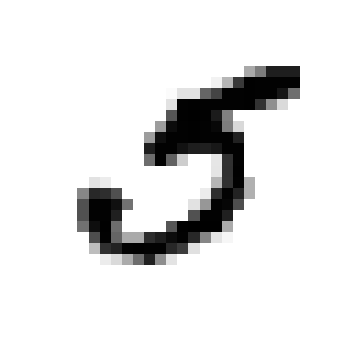

In [7]:
print(mnist.target[36000])
plt.imshow(mnist.data[36000].reshape(28, 28), 
           cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

### Train and test datasets

Our goal is to find the best predictive model on the given (mnist) dataset. 

The dataset should be split into a _training dataset_, a _validation dataset_ and a _testing dataset_ where:

- The training dataset is used to create the models
- Each model is evaluated on the validation dataset
- The best model is then evaluated on the testing dataset

The reason behind this splitting of the datasets is that a model shouldn't be evaluated on the same data used to create it. This applies in two cases:

1. Each of the initial models, created from the training dataset, should be evaluated on different dataset (the training dataset) than were used to create it
1. The best model was chosen by comparing it to many other models. This won't be the case when this model is used in practice. So we evaluate this (best) model on unseen data, which is the testing dataset

For more details on this process see [Wikipedia](https://en.wikipedia.org/wiki/Test_set#Validation_set).

We split the MNIST dataset into training datasets and testing datasets as follows. 

We have a single scaled dataset `mnist_data_scaled` of independent variables, which is split into a training dataset and a testing dataset. 

We have two target datasets:
1. `mnist.target` which is an integer variable with values `0` through `9`
1. `mnist_target_is5` which is a binary variable that is:
    - 1 if the corresponding value in `mnist.target` is a `5` 
    - 0 if the corresponding value in `mnist.target` is not a `5`

These training and testing datasets are created below. 

In [8]:
mnist_data_scaled = StandardScaler().fit_transform(mnist.data.astype(float))
mnist_target_is5  = (mnist.target==5).astype(int)

(train_data,        test_data, 
 train_target,      test_target, 
) = train_test_split(mnist_data_scaled,
                     mnist_target_is5,
                     test_size=0.2, 
                     random_state=42)

(train_data.shape,        test_data.shape, 
 train_target.shape,      test_target.shape,
)

((56000, 784), (14000, 784), (56000,), (14000,))

## Logistic regression classifier

A logistic regression model is a vector of coefficients, denoted as $\theta$.

- $m$ denotes the number of rows of the dataset.
- $x$ denotes a vector of values for the independent variable (for a row.)
- $y$ denotes a value for the binary dependent variable (for a row.)
- $x^{(i)}$ denotes the vector of values for independent variables for row $i$
- $y^{(i)}$ denotes the values of the dependent variable value for row $i$.

The goal of a classifier is to make prediction and to minimize the error/cost of these predictions.

The _logistic_ of a vector of independent variable values is
$$ \hat{p} = \sigma\left( \theta \cdot x \right)
$$
where $\cdot$ is the dot product operation and 
$$\sigma(t) = \frac{1}{1 + e^{(-t)}}
$$
is called the sigmoid function. 

The prediction, given a set of coefficients $\theta$, is denoted 
$$\hat{y} = round\left( \hat{p} \right)
$$

### Cost function

The cost function for a single row (prediction) is 
$$c(\theta, x) = 
\begin{cases}
   - \log(\hat{p})     & \text{if } y = 1
\\ - \log(1 - \hat{p}) & \text{if } y = 0
\end{cases}$$

The cost function over the entire training set (all $m$ cases) is
$$J(\theta) = - \frac{1}{m} \sum_{i=1}^{m} \left[ 
    y^{(i)} \log(\hat{p}^{(i)}) + (1-y^{(i)}) \log(1 - \hat{p}^{(i)}) 
\right]
$$
Note that this finds the cost of a model $\theta$.

### Minimizing the cost function

The function $J(\theta)$ has a single absolute minimum. It is also convex, which means that we can always find this global minimum using stochastic gradient descent (below.)


### Batch gradient descent

Any random $\theta$ vector is not likely to give the absolute mininum of the cost function $J(\theta)$, but it is straightforward to find another value for $\theta$ that provides a lesser value for $J(\theta)$. Below let $n=m$ (the number of rows.)

Each partial derivative of $J(\theta)$ 
$$ \frac{\partial}{\partial\theta_j} J(\theta) 
= \frac{1}{n} \sum_{i=1}^{n} \left( 
\sigma(\theta^T \cdot x^{(i)}) - y^{(i)}
\right)
x^{(i)}_j
$$
indicates whether to increase or decrease the corresponding coefficient of $\theta$ so that the cost function will decrease. 

New values of $\theta$ are calculated as follows:
$$ \theta_j := \theta_j - \alpha \frac{\partial}{\partial\theta_j} J(\theta)
$$
where $\alpha$ (called the _learning rate_) is greater than `0` and often less than `1`. It's value determines how much to change $\theta_j$. 
- It may take a long time to find the minimum if $\alpha$ is too small
- The minimum may be difficult to locate if $\alpha$ is too large

If the slope $\frac{\partial}{\partial\theta_j} J(\theta)$ 
- is positive then decrease $\theta_j$
- is negative then increase $\theta_j$

Recall that
- $m$ denotes the number of rows of the dataset
- $x^{(i)}$ denotes the vector of values for the independent variables for row $i$
- $y^{(i)}$ denotes the values for the dependent variable value for row $i$

### Mini-batch and stochastic gradient descent

The number of rows to use ($n$ above) can be decreased. 

When $n=1$ then we have "stochastic gradient descent". 
- Partial derivatives are computed for a row and $\theta$ is modified accordingly
- This process is repeated for each row of the dataset
- When $\theta$ reaches a minimum then the process stops

When $1<n<m$ then we have "mini-batch gradient descent." 
- Partial derivatives are computed for each batch of rows and $\theta$ is modified accordingly
- This process is repeated for each row of the dataset
- When $\theta$ reaches a minimum then the process stops

### Create the classifier

In [9]:
log_clf = LogisticRegression(solver='liblinear',
                             random_state=42)

Create the model, which means determine $\theta$

In [10]:
train_fit = log_clf.fit(train_data, 
                        train_target)

Calculate the predictions, $\hat{y} = round(\hat{p})$

In [18]:
train_predict  = train_fit.predict(train_data)
train_predict[0:6]

array([0, 0, 0, 1, 0, 0])

This implementation of logistic regression provides two addition pieces of information:

1. The probabilities $\hat{p}$
1. Decision scores 

The probabilities are returned by the `predict_proba` method.

In [13]:
train_proba    = train_fit.predict_proba(train_data)
train_proba.shape

(56000, 2)

In [14]:
train_proba[0:3]

array([[  9.99924267e-01,   7.57325288e-05],
       [  9.92572725e-01,   7.42727450e-03],
       [  9.46327650e-01,   5.36723505e-02]])

The decision scores are returned by the `decision_function` method.

In [16]:
train_decision = train_fit.decision_function(train_data)
train_decision.shape

(56000,)

The following cell compares decision scores and predictions.

In [17]:
confusion_matrix(train_decision>0, train_predict       )

array([[51372,     0],
       [    0,  4628]])

Notice that 1 is predicted if and only if the decision scores is greater than zero (`0`.)

The following cell compares decision scores and probabilities

In [21]:
confusion_matrix(train_decision>0, train_proba[:,1]>0.5)

array([[51372,     0],
       [    0,  4628]])

Notice that `1` is predicted if and only if the probability is greater than `0.5.`


## Create stochastic gradient descent (logistic regression) classifier

In [23]:
train_fit  = sgd_clf.fit(train_data, 
                         train_target)

In [24]:
test_predict = train_fit.predict(test_data)

In [25]:
test_proba    = train_fit.predict_proba(test_data)

In [26]:
test_decision = train_fit.decision_function(test_data)

In [27]:
print(confusion_matrix(test_decision>0, test_predict       ), "Compare decision scores and predictions")
print(confusion_matrix(test_decision>0, test_proba[:,1]>0.5), "Compare decision scores and probabilities")

[[13394     0]
 [    0   606]] Compare decision scores and predictions
[[13394     0]
 [    0   606]] Compare decision scores and probabilities


### Make predictions with a cross validiation classifier which uses a stochastic gradient descent logistic regression classifier

Create vector of predictions using cross validation with three (3) folds.

In [29]:
train_predict = cross_val_predict(SGDClassifier(loss='log', 
                                                alpha=0.1, 
                                                random_state=42), 
                                  train_data, 
                                  train_target, 
                                  cv=3, method='predict')
train_predict.shape

(56000,)

Create matrix of probabilities

In [30]:
train_proba = cross_val_predict(SGDClassifier(loss='log', alpha=0.1, random_state=42), 
                                  train_data, train_target, cv=3, method='predict_proba')
train_proba.shape

(56000, 2)

Verify that positive predictions correspond to probabilities over `0.5`.

In [31]:
cm = confusion_matrix(train_predict, train_proba[:,1]>0.5)
print(cm, "Compare predictions and probabilities with a confusing matrix")

[[53289     0]
 [    0  2711]] Compare predictions and probabilities with a confusing matrix


### Confusion matrix

The confusion matrix is most commonly used to compare actual values with predictions.

Below we compare `train_target` and `train_predict`.

In [32]:
pd.DataFrame(confusion_matrix(train_target, 
                              train_predict))

,0,1
0,50766,207
1,2523,2504


- The rows correspond to actual values
- The columns correspond to predictions
- The cells are row counts

### Precision and recall

These concepts differentiate the proportion of positive predictions 
- out of all of the positive predictions (precision)
- out of all of the actual positives (recall)

\begin{align}
    precision & = \frac{TP}{TP+FP}  = \frac{\text{correct positive predictions}}{\text{positive predictions}} 
\\  recall    & = \frac{TP}{TP+FN}  = \frac{\text{correct positive predictions}}{\text{actual positives}}
\end{align}
Where:
- TP: true positive = positive prediction, actual positive (2504)
- TN: true negative = negative prediction, actual negative (50766)
- FP: false positive = positive prediction, actual negative (207)
- FN: false negative = negative prediction, actual positive (2523)

Counts in refer to the table above.

In [34]:
print("precision: ",precision_score(train_target, train_predict))
print("   recall: ",   recall_score(train_target, train_predict))

precision:  0.923644411656
   recall:  0.498110204894


- Precision: 92% of positive predictions are correct
- Recall: 50% of actual positives are identified as positive

### Probabilities and ROC curve

Some classifiers can return probabilities for each case (as shown above.)

We repeat the cross-validation code from above. 

In [35]:
train_proba = cross_val_predict(SGDClassifier(loss='log', alpha=0.1, random_state=42), 
                                        train_data, train_target, 
                                        method='predict_proba', cv=3)
train_proba.shape

(56000, 2)

Retrieve the probabilities that any row is classified as `0` or `1`.

In [36]:
train_proba_0 = train_proba[:,0]
train_proba_1 = train_proba[:,1]

Create vector of predictions using cross validation with three (3) folds.

In [37]:
train_predict = cross_val_predict(SGDClassifier(loss='log', alpha=0.1, random_state=42), 
                                  train_data, train_target, cv=3, method='predict')
train_predict.shape

(56000,)

In [16]:
def tfpr(threshold, target, proba_1):
    predict = (proba_1>threshold).astype(int)
    cm = confusion_matrix(target, predict)
    tp = cm[1,1]
    tn = cm[0,0]
    fp = cm[0,1]
    fn = cm[1,0]
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return(tpr, fpr)

In [20]:
tfpr(0.5, train_target, train_predict)

(0.49811020489357472, 0.0040609734565358133)

In [23]:
tfpr_array = np.array([tfpr(x, train_target, train_proba_1) for x in list(np.arange(0.0,1.0,0.01))])

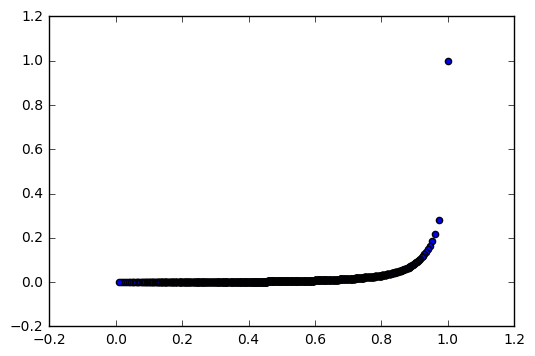

In [24]:
plt.scatter(tfpr_array[:,1],tfpr_array[:,0])

In [39]:
fpr, tpr, thresholds = roc_curve(train_target, train_decision)
fpr.shape, tpr.shape, thresholds.shape

((1869,), (1869,), (1869,))

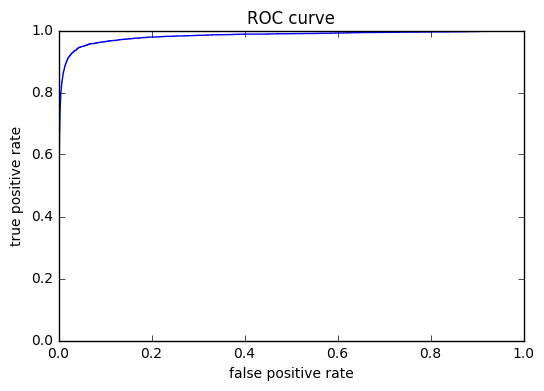

In [40]:
plt.title("ROC curve")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.plot(fpr,tpr)

In [73]:
roc_auc_score(train_target, train_decision)

0.96670627269874865

### Appendix

#### Normal equation

$$\hat{\theta} = \left( X^T \cdot X \right)^{-1} \cdot X^T \cdot y
$$

where:
- $X$ denotes the two dimensional matrix of independent variables values for all rows
- $y$ denotes the vector of dependent variable values

This works well if there are not too many rows, but may take too much memory or take too long if there if there are many rows. In these cases one uses _stochastic gradient descent_.

#### Find classes with `predict_proba` methods

In [ ]:
from sklearn.utils.testing import all_estimators

estimators = all_estimators()

for name, class_ in estimators:
    if hasattr(class_, 'predict_proba'):
        print(name)